In [1]:
from tabulate import tabulate
from sklearn import preprocessing
from numpy.linalg import norm

In [2]:
import re
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from progressbar import Percentage, ProgressBar,Bar,ETA

In [3]:
# import pickle
# from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [109]:
import io

def getVectorsFromFasttext():
    for fold in range(0,5):
        fin = io.open('./cc.hi.300.vec', 'r', encoding='utf-8', newline='\n', errors='ignore')
        train_verbs_set = pd.read_csv('../data/train_samples-fold{}_2.csv'.format(fold), delimiter='\t')
        test_verbs_set = pd.read_csv('../data/test_samples-fold{}_2.csv'.format(fold), delimiter='\t')
        train_verbs = train_verbs_set['Verb']
        test_verbs = test_verbs_set["Verb"]
        x = fin.readline().split()
        tokens = []
        vector = []
        while x:
            if x[0] in list(train_verbs) or x[0] in list(test_verbs):
                tokens.append(x[0])
                vector.append(x[1:])
            x = fin.readline().split()
#         for verb in list(train_verbs):
#             while x:
#                 if verb == x[0]:
#                     found = 1
#                     tokens.append(x[0])
#                     vector.append(x[1:])
#                 x = fin.readline().split()
#             if found ==0:
#                 print(verb)
#         for verb in list(test_verbs):
#             while x:
#                 if verb == x[0]:
#                     found = 1
#                     tokens.append(x[0])
#                     vector.append(x[1:])
#                 x = fin.readline().split()
#             if found ==0:
#                 print(verb)
        
        all_ = [tokens, vector]
        with open('verbs-fold{}.csv'.format(fold), 'w') as f:
            for i in range(0, len(tokens)):
                f.write(all_[0][i])
                f.write('\t')
                for j in range(0, 300):
                    f.write(all_[1][i][j])
                    f.write('\t')
                f.write('\n')

In [154]:
# getVectorsFromFasttext()

In [4]:
def get_all_verbs_vector():
    vec = []
    for i in range(0,300):
        vec.append(i)
    vec = ['verb'] + vec + ['remove']
    verb1 = pd.read_csv('verbs-fold1.csv', delimiter='\t', names=vec)
    verb1 = verb1.drop(columns='remove')

    verb0 = pd.read_csv('verbs-fold0.csv', delimiter='\t', names=vec)
    verb0 = verb0.drop(columns='remove')

    verb2 = pd.read_csv('verbs-fold2.csv', delimiter='\t', names=vec)
    verb2 = verb2.drop(columns='remove')

    verb3 = pd.read_csv('verbs-fold3.csv', delimiter='\t', names=vec)
    verb3 = verb3.drop(columns='remove')

    verb4 = pd.read_csv('verbs-fold4.csv', delimiter='\t', names=vec)
    verb4 = verb4.drop(columns='remove')


    all_verbs = pd.concat([verb0, verb1, verb2, verb3, verb4])
    all_verbs = all_verbs.drop_duplicates(subset=['verb'])
    all_verbs.to_csv('./all_verb_vectors.csv', sep = '\t', index=False)
    return all_verbs

In [153]:
# all_verbs = get_all_verbs_vector()

In [120]:
#CHECK number of rows
#run get_all_verbs_vector^^^
#run g() again

In [10]:
def getResult(y_true, predicted, fold):
    print('Results...')
    y_pred = list(predicted)
    labels = ['+','-','0','t+','t-','na']
    recall = recall_score(y_true, y_pred, labels=labels, average=None)
    precision = precision_score(y_true, y_pred, labels=labels, average=None)
    f1 = f1_score(y_true, y_pred, labels=labels, average=None)
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    fig = plt.subplots(figsize=[6,6])
    fig = sns.heatmap(cm/np.sum(cm), fmt='.2%',annot=True, cmap='Blues', cbar=False)
    plt.xticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5], labels)
    plt.yticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5], labels)
    plt.xlabel('Predicted Category')
    plt.ylabel('Actual Category')
    plt.title('Fold #{}'.format(fold))
    recall = np.reshape(recall, (-1, 1))
    precision = np.reshape(precision, (-1, 1))
    f1 = np.reshape(f1, (-1, 1))
    labels = np.reshape(np.array(labels), (-1, 1))
    header = [' ','Recall', 'Precision', 'F1-score']
    header = np.array(header)


    res = np.hstack((labels,recall,precision,f1))
    result = np.vstack((header, res))
    h = result[0]
    result = np.delete(result, (0), axis=0)

    print(tabulate(result, headers=h, tablefmt="fancy_grid"))
    print("meanf1:", np.mean(f1))
    print("meanPrecision:", np.mean(precision))
    print("meanRecall:", np.mean(recall))

In [11]:
def predictLabel(train_samples, train_labels, test_samples, test_labels, fold, train_v, test_v):
    assert (len(test_v) == len(test_samples) == len(test_labels))
    predicted_labels = []
    test_idx=0
    for test_sample in test_samples:
        max_cosine = -99999999
        a_label = ''
        A = np.array(test_sample)
        idx = 0
        for train_sample, label in zip(train_samples, train_labels):
            B = np.array(train_sample)
            cosine = np.dot(A,B)/(norm(A)*norm(B))
            if(cosine > max_cosine):
                closest_v = idx
                max_cosine = cosine
                a_label = label
            idx += 1
        predicted_labels.append(a_label)
        same_verb_count = 0
        if test_v[test_idx] != train_v[closest_v]:
            print("closest", test_v[test_idx], train_v[closest_v])
            print("label predited:",predicted_labels[test_idx], "correct:", test_labels[test_idx])
        else:
            same_verb_count+=1
        test_idx += 1
    print("Number of verbs in test that are present in train", same_verb_count)
    getResult(test_labels, predicted_labels, fold)
    

In [42]:
def g():
    # all_verbs = get_all_verbs_vector() OR
    all_verbs = pd.read_csv('./all_verb_vectors.csv', delimiter='\t')
    verb_vector_dict = {}
    for i in range(len(all_verbs.index)):
        row = all_verbs.loc[i, :].values.tolist()
        verb = row[0]
#         print(verb)
        vector = row[1::]
        verb_vector_dict[verb] = vector
#     verb_cat = pd.read_csv('../../data/annotation/verbs/verb_names.txt', delimiter=',')
#     verb_cat = verb_cat.drop(['InSeed'], axis=1)
#     verb_cat_dict = dict(verb_cat.values)
    for fold in range(0,5):
        print("-------------------FOLD #{}-------------------------".format(fold))
        train_verbs_set = pd.read_csv('../data/train_samples-fold{}_2.csv'.format(fold), delimiter='\t')
        test_verbs_set = pd.read_csv('../data/test_samples-fold{}_2.csv'.format(fold), delimiter='\t')
#         train_verbs_set = train_verbs_set.drop_duplicates(subset=['Verb'])
#         test_verbs_set = test_verbs_set.drop_duplicates(subset=['Verb'])
        train_verbs = list(train_verbs_set['Verb'])
        test_verbs = list(test_verbs_set["Verb"])
        train_labels = list(train_verbs_set["label"])
        test_labels = list(test_verbs_set["label"])
        train_samples = []
        test_samples = []
        
        for verb in train_verbs:
            try:
                train_samples.append(verb_vector_dict[verb])
            except:
                print("train", verb)
                train_samples.append([0] * 300)
            
        for verb in test_verbs:
            try:
                test_samples.append(verb_vector_dict[verb])
            except:
                print("test", verb)
                test_samples.append([0] * 300)
        
        predictLabel(train_samples, train_labels, test_samples, test_labels, fold, train_verbs, test_verbs)

In [41]:
g()

-------------------FOLD #0-------------------------
train मार्करऔर
train ढू़ँढ़
closest समझ सोच
closest पिल्ला पालतू
closest पिल्ला पालतू


KeyboardInterrupt: 

In [ ]:
# miss = set(train_verbs_set['Verb']).symmetric_difference(test_verbs_set['Verb'])

In [ ]:
# test_verbs_set.loc[test_verbs_set['Verb'].isin(miss)]

In [6]:
def g_unique():
    # all_verbs = get_all_verbs_vector() OR
    all_verbs = pd.read_csv('./all_verb_vectors.csv', delimiter='\t')
    verb_vector_dict = {}
    for i in range(len(all_verbs.index)):
        row = all_verbs.loc[i, :].values.tolist()
        verb = row[0]
#         print(verb)
        vector = row[1::]
        verb_vector_dict[verb] = vector
#     verb_cat = pd.read_csv('../../data/annotation/verbs/verb_names.txt', delimiter=',')
#     verb_cat = verb_cat.drop(['InSeed'], axis=1)
#     verb_cat_dict = dict(verb_cat.values)
    for fold in range(0,5):
        print("-------------------FOLD #{}-------------------------".format(fold))
        train_verbs_set = pd.read_csv('../data/train_samples-fold{}_2.csv'.format(fold), delimiter='\t')
        test_verbs_set = pd.read_csv('../data/test_samples-fold{}_2.csv'.format(fold), delimiter='\t')
        train_verbs_set = train_verbs_set.drop_duplicates(subset=['Verb'])
        test_verbs_set = test_verbs_set.drop_duplicates(subset=['Verb'])
        train_verbs = list(train_verbs_set['Verb'])
        test_verbs = list(test_verbs_set["Verb"])
        train_labels = list(train_verbs_set["label"])
        test_labels = list(test_verbs_set["label"])
        train_samples = []
        test_samples = []
        
        for verb in train_verbs:
            try:
                train_samples.append(verb_vector_dict[verb])
            except:
                print("train", verb)
                train_samples.append([0] * 300)
            
        for verb in test_verbs:
            try:
                test_samples.append(verb_vector_dict[verb])
            except:
                print("test", verb)
                test_samples.append([0] * 300)
        
        predictLabel(train_samples, train_labels, test_samples, test_labels, fold, train_verbs, test_verbs)

-------------------FOLD #0-------------------------
train मार्करऔर
train ढू़ँढ़
closest समझ सोच
label predited: + correct: +
closest पिल्ला पालतू
label predited: na correct: na
closest काँटा छीला
label predited: - correct: na
closest बेसन बर्तन
label predited: na correct: na
closest फूल फल
label predited: na correct: +
closest मंडी बिक
label predited: - correct: na
closest पाल सोहन
label predited: na correct: +
closest खिला पिला
label predited: + correct: +
closest मण्डी ख़रीदी
label predited: t+ correct: na
closest पसंद चाह
label predited: + correct: na
closest उड़ा उड़
label predited: - correct: +
closest चर खा
label predited: - correct: -
closest झूल गिर
label predited: - correct: +
closest शेरोन बेनी
label predited: na correct: na
Number of verbs in test that are present in train 1
Results...
╒═════╤══════════╤═════════════╤════════════╕
│     │   Recall │   Precision │   F1-score │
╞═════╪══════════╪═════════════╪════════════╡
│ +   │ 0.909091 │    0.980392 │   0.943396 │
├─────┼─

╒═════╤══════════╤═════════════╤════════════╕
│     │   Recall │   Precision │   F1-score │
╞═════╪══════════╪═════════════╪════════════╡
│ +   │ 0.920635 │    0.935484 │   0.928    │
├─────┼──────────┼─────────────┼────────────┤
│ -   │ 0.96     │    0.888889 │   0.923077 │
├─────┼──────────┼─────────────┼────────────┤
│ 0   │ 1        │    1        │   1        │
├─────┼──────────┼─────────────┼────────────┤
│ t+  │ 1        │    0.833333 │   0.909091 │
├─────┼──────────┼─────────────┼────────────┤
│ t-  │ 1        │    1        │   1        │
├─────┼──────────┼─────────────┼────────────┤
│ na  │ 0.636364 │    0.777778 │   0.7      │
╘═════╧══════════╧═════════════╧════════════╛
meanf1: 0.9100279720279721
meanPrecision: 0.9059139784946236
meanRecall: 0.9194997594997595


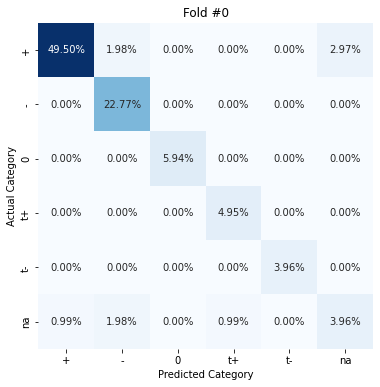

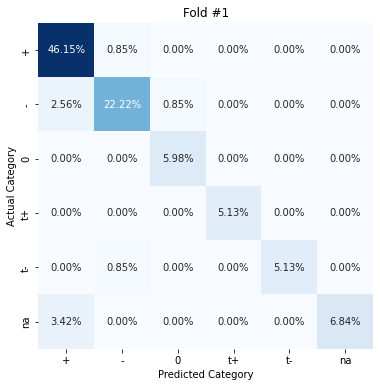

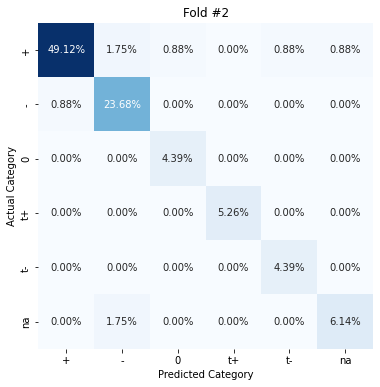

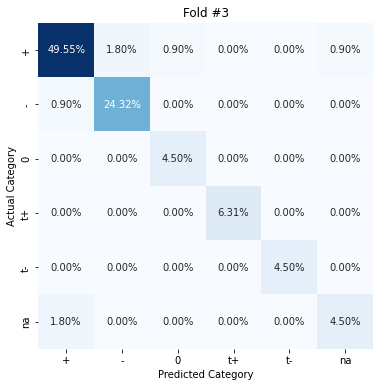

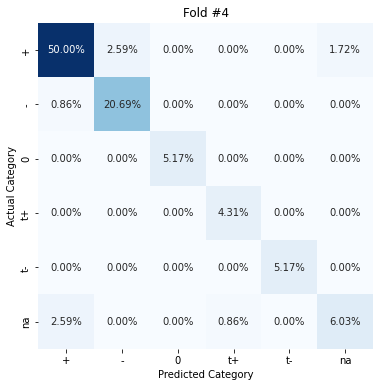

In [12]:
g_unique()